<table align="left" style="border-style: hidden" class="table"> <tr><td class="col-md-2"><img style="float" src="http://prob140.org/assets/icon256.png" alt="Prob140 Logo" style="width: 120px;"/></td><td><div align="left"><h3 style="margin-top: 0;">Probability for Data Science</h3><h4 style="margin-top: 20px;">UC Berkeley, Fall 2019</h4><p>Ani Adhikari and Jim Pitman</p>CC BY-NC 4.0</div></td></tr></table><!-- not in pdf -->

In [1]:
# SETUP

import itertools
import numpy as np
from datascience import *
from prob140 import *

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# These lines make warnings look nicer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Useful for probability calculations
from scipy import stats
from scipy import special

In [2]:
def _remove_gaps(domain, prob):
    """
    domain must be sorted
    """
    new_probs = []
    index = 0
    max_value = max(domain)
    for i in range(max_value + 1):
        if i < domain[index]:
            new_probs.append(0)
        else:
            new_probs.append(prob[index])
            index += 1
    return np.array(new_probs)

In [3]:
def plot_sample(p_array, s, m):
    """
    Plots a dot plot sampled s times from p_array.
    
    Parameters
    ----------
    p_array : array
        An array of probabilities corresponding to p_0, ..., p_n.
    s : int
        Sample size.
    m : int
        Highlighted value.
    """
    assert s % 2 == 1, 's must be odd.'
    n = len(p_array)
    samples = sorted(np.random.choice(np.array(n), size=s, p=p_array))
    counts = _remove_gaps(*np.unique(samples, return_counts=True))
    for i in range(n):
        if i < len(counts):
            x = [i] * counts[i]
            y = np.arange(counts[i])
            if i == m:
                color = 'k'
                plt.vlines(i, -1, max(10, max(counts)), linewidth=1,
                           color='blue',lw=2, label='m')
            else:
                color = 'k'
            plt.scatter(x, y, color=color, s=40)
    median_value = samples[s // 2]
    # If there multiple instance of the median value, want to know which
    # one is the real median.
    median_index = s // 2 - samples.index(median_value)
    plt.scatter(median_value, median_index, color='r', s=40,
                label='median')
    plt.axhline(-1, color='k')
    plt.xlim(-0.5, n - 0.5)
    ax = plt.gca()
    ax.set_xticks(np.arange(n))
    ax.set_yticks([])
    ax.grid(False)
    plt.ylim(-1, max(10, max(counts)))
    plt.legend()
    if median_value > m:
        print('Sample median is greater than m.')
    else:
        print('Sample median is not greater than m.')
    plt.title('Sample Median')


## Lab Resources

* [`prob 140` Library Documentation](http://prob140.org/prob140/)
* [Data 8 Python Reference](http://data8.org/fa18/python-reference.html)
* [Prob 140 Code Reference Sheet](http://prob140.org/assets/prob140_code_reference.pdf)
* [`scipy.stats` Documentation](https://docs.scipy.org/doc/scipy/reference/stats.html)

# Lab 3: Expectations of Discrete Order Statistics #
Additivity is a powerful property of expectation: you have seen several examples in which writing a random variable as a sum of simpler variables has led to a simple calculation of its expected value. But other methods are needed for finding the expectations of random variables that can't easily be written as sums. 

Using the basic definition of expectation is one such method, and it works well when you can easily write down the distribution of the random variable and have the computational tools to work out the resulting sum. However, distributions aren't always straightforward to write down.

This lab is about expectations of a class of random variables that don't have natural representations as sums of simpler variables. These variables, called *order statistics*, can be thought of as the elements of a random sample arranged in increasing order. We will work with just two of them:
- the minimum
- the median

You have used the sample median as a statistic in Data 8. How big is a random sample median expected to be? By the end of this lab you will have an answer to this question. 

The corresponding question for the sample mean has an easy answer by additivity: the expectation of a random sample mean is the population mean. But additivity isn't very helpful for medians as medians aren't easy to think of as sums. A different approach is needed.

For expectations of random sample order statistics, the *tail sum formula* is an excellent approach if the values in the population are non-negative integers.

What you will learn in this lab:

- How to calculate tail probabilities for a random sample minimum
- How to calculate tail probabilities for a random sample median
- How to compute expectations using the tail sum formula
- How to find the expected minimum value in a random sample
- How to find the expectation of a random sample median
- How random sample medians behave as the sample size gets large

As a starting point, let's see how to calculate tail probabilities for the minimum and the median of a random sample.

## Instructions
Your labs have two components: a written portion and a portion that also involves code. Written work should be completed on paper, and coding questions should be done in the notebook. If a question does not begin with [ON PAPER]. then it should be done in the notebook. You are welcome to LaTeX your answers to the written portions, but staff will not be able to assist you with LaTeX related issues. It is your responsibility to ensure that both components of the lab are submitted completely and properly to Gradescope. Refer to the bottom of the notebook for submission instructions.

## Part 1: Tails of Order Statistics — The Math ##
Let $X$ be a random variable with values $0, 1, 2, 3, \ldots, N$ for some fixed integer $N$. As you know, the cumulative distribution function (cdf) of $X$ is the function $F_X$ defined by
$$
F_X(x) ~ = ~ P(X \le x) 
$$
for all $x$.

We will define the *tail probability function* $T_X$ by

$$
T_X(x) ~ = ~ P(X > x) ~ = ~ 1 - F_X(x)
$$
for all $x$.

Here is the probability histogram of a random variable with distribution `example_dist`. The gold area is equal to $F_X(4)$ and the blue area is $T_X(4)$.

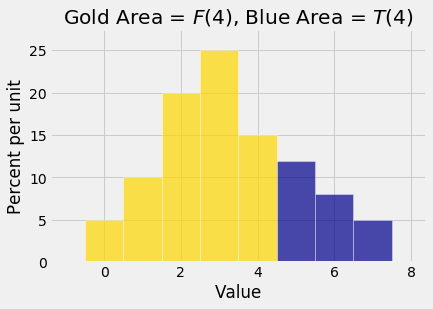

In [4]:
example_vals = np.arange(8)
example_probs = make_array(0.05, 0.1, 0.2, 0.25, 0.15, 0.12, 0.08, 0.05)

example_dist = Table().values(example_vals).probabilities(example_probs)

Plot(example_dist, event = np.arange(5))

plt.title('Gold Area = $F(4)$, Blue Area = $T(4)$');

Tail probabilities can be very useful. As you have already seen, they can be used to find the distribution:

$$
P(X = k) ~ = ~ T_X(k-1) - T_X(k)
$$

In lectures you will also have seen that tail probabilities can also be used to find the expectation of a non-negative integer valued random variable.

So it's a good idea to be able to calculate them easily. In this part of the lab, you will develop formulas for the tail probabilities of two commonly used statistics.

### 1a) [ON PAPER] Tails of a Random Sample Minimum ###

Let's start by setting up the notation that will be used throughout the lab.

Let $X$ have possible values $0, 1, 2, \ldots, N$. Let $p_i = P(X = i)$ for $0 \le i \le N$. Then $p_i \ge 0$ for all $i$ and $\sum_{i=0}^N p_i = 1$.

We will call the sequence $p_0, p_1, \ldots, p_N$ the *probability array* of $X$. 

Let the tail probabilities of $X$ be defined by the function $T_X$ as before:

$$
T_X(k) ~ = ~ P(X > k), ~~ 0 \le k \le N
$$

Now let $X_1, X_2, \ldots, X_n$ be i.i.d. random variables, each with the probability array $p_0, p_1, \ldots, p_N$. 

Let $Y$ be the smallest of the $n$ sampled values, that is, let $Y ~ = ~ \min\{X_1, X_2, \ldots , X_n\}$.

For every integer $k$ such that $0 \le k \le n$, find $P(Y > k)$ in terms of the function $T_X$, the sample size $n$, and of course $k$.

Your formula should be quite simple. Things get more interesting when you try to find the tail probabilities of a random sample median. Get ready for a special appearance by one of the superstar probability distributions.

### 1b) The Event "Sample Median $> m$" ###
We will analyze the tails of the sample median in the straightforward case where the sample size $s = 2n+1$ is odd and "the median" is defined as the $(n+1)$st value when the sample is sorted in ascending order. The $(n+1)$st is the right item to pick out, because $2n+1 = n + 1 + n$.

This sample median is formally known as the *$(n+1)$st order statistic* of the sample.

The example below will help clarify the definition.

In [5]:
# 9 = 2*4 + 1

sample_9 = make_array(23, 81, 34, 13, 56, 27, 26, 34, 22)
sample_9_median = np.sort(sample_9).item(4)       # item(4) is the 5th item
sample_9_median

27

Let $X_1, X_2, \ldots, X_n$ be i.i.d., each with probability array $[p_0, p_1, \ldots, p_N]$. In our first example we are going to use `example_probs` as this array.

In [6]:
example_probs

array([0.05, 0.1 , 0.2 , 0.25, 0.15, 0.12, 0.08, 0.05])

Start by visualizing what has to happen for the sample median to be larger than a given value. The function `plot_sample` takes three arguments:
- a probability array of our usual form $[p_0, p_1, \ldots, p_N]$
- an odd numbered sample size $s = 2n+1$ for some non-negative integer $n$
- a value of $m$

It displays a dot plot of an i.i.d. sample of size $s$ drawn from the probability array (remember that the possible values are $0, 1, \ldots, N$). The vertical blue line is at $m$. The statement above the plot says whether or not the sample median is greater than $m$.

Run the cell below many times just as written. Each time, count how many dots are on the right of the vertical line, and note whether or not the median is bigger than $m$. Then change $m$ and $s$ and run it again a few times, but don't go too crazy with the changes.

Sample median is not greater than m.


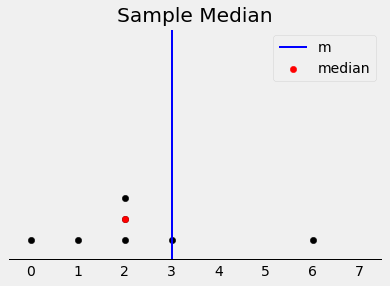

In [7]:
plot_sample(example_probs, 7, 3)

Fill in the blank with the appropriate phrase. You might want to go back and run the previous cell a few more times.

The median of a sample of size $2n+1$ is bigger than $m$ if and only if $\underline{~~~~~~~~~~~~~~~~}$ of the sampled elements are bigger than $m$.

$\underline{The \space Majority}$

### 1c) [On Paper] Tails of a Random Sample Median ###
Let $s = 2n+1$. Let $X_1, X_2, \ldots , X_s$ be i.i.d., each with possible values $0, 1, 2, \ldots, N$ and tail probability function $T_X$. 

Let $M$ be the median of $X_1, X_2, \ldots, X_s$, as defined above. 

**Fix an integer $m$ in the range 0 through $N$.** 

In **1b** you wrote the event $\{ M > m \}$ in terms of a random count: the number of sampled elements that are bigger than $m$. 

**Question 1.** When you counted the number of points to the right of the vertical line in **1b**, did you need to use the exact location of each sampled point, or was it enough just to answer a yes/no question for each point?

**Question 2.** Give the random count a name: let $R_m$ be the number of sampled elements that are bigger than $m$. That is, $R_m$ is the number of points to the right of the vertical line at $m$.

Fill in the blanks and **explain your answers**. The first blank should be filled with the name of a famous distribution. The second blank should contain the parameters in terms of the sample size $s$, the tail probability function $T_X$, and $m$.

$R_m$ has the $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$ distribution with parameters $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$.

**Question 3.** Now fill in the first blank below with a math operation and an expression in terms of the sample size $s$.

For every integer $m$ in the range 0 through $N$, $P(M > m) = P(R_m \underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~})$. 

Thus the tail probabilities for the sample median can be found by using the distribution in the answer to Question 2 above.

#newpage

## Part 2: Tail Sum Formula for Expectation ##

For $X$ with probability array $p_0, p_1, \ldots, p_N$, the expectation is defined as

$$
E(X) ~ = ~ p_1 + 2p_2 + 3p_3 + \cdots + Np_N
$$

For non-negative integer valued random variables, there is also an alternative formula. As you have seen, the *tail sum formula* allows you to calculate the expectation of such a random variable based on the tail probabilities alone:

$$
E(X) = T_X(0) + T_X(1) + \cdots + T_X(N-1) + T_X(N)
$$

In the sum above, the last term $T(N)$ is 0. So you can stop the sum at $T(N-1)$, but it doesn't hurt to include $T(N)$.

**The tail sum formula says that to find the expectation of a non-negative integer valued random variable, you can just add up all the tail probabilities.**

**Note.** If $X$ has infinitely many possible values $0, 1, 2, 3, \ldots$, then its expectation can be calculated as the infinite sum $E(X) = \sum_{i=0}^\infty T_X(i)$. But you won't need that in this lab.

In this part of the lab, you will implement the tail sum formula and find the expectation of a random sample minimum.

### 2a) Computing Tail Probabilities ###

Let a random variable $X$ with possible values $0, 1, 2, \ldots, N$ have probability array $p_0, p_1, \ldots, p_N$. 

Define a function `tails` that takes the probability array as its argument and returns an array of values $T_X(k)$ for $0 \le k \le N$. Remember the word "cumulative" in cdf, and use `np.cumsum` appropriately.

In [8]:
def tails(prob_array):
    values = np.array([])
    i = 0
    while i < len(prob_array):
        i += 1
        values = np.append(values, sum(prob_array[(i):]))
    return values

Suppose $p_0 = 0.3$, $p_1 = 0.5$, and $p_2 = 0.2$, and let `probs` be the array [0.3, 0.5, 0.2].

What should `tails(probs).item(0)` and `tails(probs).item(2)` evaluate to? Check that they work out as they should.

In [9]:
probs = make_array(0.3, 0.5, 0.2)

tails(probs).item(0), tails(probs).item(2)

(0.7, 0.0)

### 2b) Checking the Tail Sum Formula ###
Let $X$ have the distribution given in the table `example_dist` from Part 1.

In [10]:
example_dist

Value,Probability
0,0.05
1,0.1
2,0.2
3,0.25
4,0.15
5,0.12
6,0.08
7,0.05


Remember that `example_dist` is just an ordinary Table. Write an expression that evaluates to $E(X)$, by using array operations and the original definition of expectation.

In [11]:
sum(example_dist['Value']*example_dist['Probability'])

3.2800000000000002

The probability array of $X$ is `example_probs`:

In [12]:
example_probs

array([0.05, 0.1 , 0.2 , 0.25, 0.15, 0.12, 0.08, 0.05])

Write an expression that evaluates to $E(X)$ by using your function `tails` and the tail sum formula. 

In [13]:
sum(tails(example_probs))

3.28

### 2c) Expectation of a Random Sample Minimum ###
Let $X_1, X_2, \ldots, X_n$ be i.i.d. random variables and let $Y_n = \min \{ X_1, X_2, \ldots , X_n \}$ be the sample minimum. 

Define a function `expected_sample_min` that takes the probability array of $X_1$ as the first argument and the sample size $n$ as the second, and returns $E(Y)$. 

Use the function `tails` that you defined earlier in this part of the lab, the tail sum formula, as well as the formula you derived in **1a**.

In [14]:
def expected_sample_min(prob_array, n):
    return sum(tails(prob_array)**n)

To check if your function works, let $X_1$ and $X_2$ be i.i.d. uniform on 0, 1, and 2, and let $Y = \min(X_1, X_2)$. Use the lines of the cell below to compute the distribution of $Y$ without using tails. Just enumerate all the outcomes and hence find $E(Y)$ by applying the original definition. The last line of code should evaluate to $E(Y)$.

In [21]:
# P(Y = 0)
p_y_0 = 5/9

# P(Y = 1)
p_y_1 = 3/9

# P(Y = 2)
p_y_2 = 1/9

# E(Y)
p_y_0*0 + p_y_1*1 + p_y_2*2

0.5555555555555556

Now check that your function works. Start by defining the probability array you need as the first argument. The last line of code should evaluate to the answer you got above.

In [24]:
probs = (1/3) * np.ones(3)
expected_sample_min(probs, 2)

0.5555555555555556

### 2d) Expected Minimum Household Size in Sample ###

The website Statista provides the [distributions of household sizes](https://www.statista.com/statistics/242189/disitribution-of-households-in-the-us-by-household-size/) in the United States, for various years. Go to the website and notice their choice of stacked bars representing the proportions of households of different sizes. If you hover your cursor over one of the stacks, you can see the percents in that stack. Notice also:
- No household has 0 members, so the bottom bar (blue) represents households with one member.
- The distributions have been *truncated* at 7. That is, the last category of sizes is "7 or more". This truncation could markedly affect the calculation of average household size, so we won't do that. However, it will have little effect on the minimum household size in the sample and on the sample median. 

Let's start with the 2018 distribution. We'll call the final category "7 persons", not "7 or more". So everything we do using these proportions will be an approximation, not an exact value.

First, run the cells below for some cleanup to compensate for the fact that the proportions provided don't quite add up to 1. The array `hh_size_2018` is the household size probability array for 2018: there are no households with 0 members, roughly 28% with 1 member, and so on. We have just normalized Statista's proportions by the total and rounded the results.

In [17]:
statista = make_array(0.2801, 0.3452, 0.1515, 0.1291, 0.0583, 0.0223, 0.0134)
hh_size_2018 = np.append(0, statista)
hh_size_2018 = np.round(hh_size_2018/sum(hh_size_2018), 5)
hh_size_2018

array([0.     , 0.28013, 0.34523, 0.15152, 0.12911, 0.05831, 0.0223 ,
       0.0134 ])

In [18]:
sum(hh_size_2018)

0.9999999999999998

Use your function `expected_sample_min` to write one line of code that evaluates to the expected minimum household size in a random sample of 100 households from 2018.

In [19]:
expected_sample_min(hh_size_2018, 100)

0.9999999999999831

Does the answer make intuitive sense? Explain.

Yes I believe this answer makes sense. There is a 28.013% chance for each household to have a count of 1 for every household in the SRS of 100 households. Thus, out of 100 draws, it is highly likely that there will be at least one household with only 1 person in it, thus making the minimum 1. In fact, as the SRS size, n, increases, the expected value will continue getting closer to 1 since the chance that at least 1 household of only 1 person will be in the SRS increases as well. One thing to keep in mind here is that, for some reason, python seems to misrepresent the number 1.00e+000 as just a little bit less then 1 which is causing the expected_sample_min to  return a number which is a tiny bit less then 1.

#newpage

## Part 3: Computing the Expected Sample Median ##

The goal of this part is to write a function that computes the expectation of a random sample median using the formula you derived in Part 1. 

For this, it will help to have two computational preliminaries.

### 3a) Odd or Even? ###
The Python operator `%` operates on two numbers `a` and `b` where `b` is non-zero, and returns the remainder after `a` is divided by `b`. The expression

`a % b`

evaluates to the remainder of `a` divided by `b`.

For example, the remainder of 14 divided by 4 is 2, because $14 = (4*3) + 2$.

In [20]:
14 % 4

2

Use `%` to define a function `is_odd` that takes non-negative integer as its argument and returns `True` if the argument is odd and `False` otherwise.

In [21]:
def is_odd(n):
    return n%2 != 0

### 3b) Binomial CDF and Tails ###
Let $n$ and $k$ be integers such that $0 \le k \le n$, and let $p \in (0, 1)$.

You know that `stats.binom.pmf(k, n, p)` evaluates to $\binom{n}{k} p^k (1-p)^{n-k}$, the probability mass of the binomial $(n, p)$ distribution at the value $k$.

Also, `stats.binom.cdf(k, n, p)` evaluates to the cumulative distribution function (cdf) of the binomial $(n, p)$ distribution, evaluated at $k$. That is, it evaluates to $P(W \le k)$ where $W$ has the binomial $(n, p)$ distribution.

That's the chance of at most $k$ successes in $n$ independent repeated trials with chance $p$ of success on each trial.

As a numerical example, let $W$ have the binomial $(100, 0.7)$ distribution. Use `stats.binom.cdf` to write an expression that evaluates to the tail probability $P(W > 75)$.

In [22]:
1-stats.binom.cdf(75, 100, 0.7)

0.11357018170418143

To get the cdf of the binomial $(n, p)$ distribution at an array `x` of possible values, use `stats.binom.cdf(x, n, p)`.

For example, here is the cdf of the binomial (100, 0.5) distribution evaluated at the points 45, 50, and 55.

In [23]:
stats.binom.cdf(make_array(45, 50, 55), 100, 0.5)

array([0.18410081, 0.53979462, 0.86437349])

When you use `stats.binom` methods, you can replace other arguments by arrays too. For example, suppose you have three biased coins that land heads with chance 0.2, 0.3, and 0.4, and for each of them you want the chance of getting 4 heads in 7 tosses. The expression in the cell below evaluates to an array containing the three chances.

In [24]:
stats.binom.pmf(4, 7, make_array(0.2, 0.3, 0.4))

array([0.028672 , 0.0972405, 0.193536 ])

I have 9 coins. For each $i$ in the range 1 through 9, Coin $i$ lands heads with chance $p_i = i/10$. Write an expression that evaluates to an array consisting of the following tail probabilities:

$$
P(\text{more than 3 heads in 8 tosses of Coin } i), ~~~ i = 1, 2, 3, \ldots, 9
$$

In [25]:
1 - stats.binom.cdf(3, 8, make_array(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9))

array([0.00502435, 0.0562816 , 0.19410435, 0.4059136 , 0.63671875,
       0.8263296 , 0.94203235, 0.9895936 , 0.99956835])

### 3c) Expectation of the Sample Median ###
You are now ready to compute the expectation of a random sample median.

Define a function `expected_sample_median` that takes as its arguments a probability array of the form $[p_0, p_1, \ldots, p_N]$ and a sample size, and returns:
- the string `'For this calculation, the sample size has to be an odd number.'` if the sample size is even
- the expectation of the median of an i.i.d. sample of the given size from the given array, if the sample size is odd

You will need:

- The tail sum formula
- Your answers to **1c**
- The computational preliminaries **3a** and **3b**

In [26]:
def expected_sample_median(prob_array, s):
    if is_odd(s):
        Rm = 1 - stats.binom.cdf(np.floor(s/2), s, tails(prob_array))
        return sum(Rm)
    else:
        return 'For this calculation, the sample size has to be an odd number.'
print(example_probs)
expected_sample_median(example_probs, 9)

[0.05 0.1  0.2  0.25 0.15 0.12 0.08 0.05]


3.141111959305138

# Run the cell below to confirm that your function is doing the right thing. It uses the probability array `example_probs` from Part 1.

In [27]:
expected_sample_median(example_probs, 10)

'For this calculation, the sample size has to be an odd number.'

You can also check an edge case.

If the sample size is 1, then there's just one value $X_1$ in the sample, and that's the median. So if the sample size is 1 then $M = X_1$ and hence $E(M) = E(X_1)$. 

Check that your function does the right thing in the cell below. The value you should get is in **2b**.

In [28]:
expected_sample_median(example_probs, 1)

3.2800000000000002

### 3d) Expected Sample Median Household Size ###

In the cell below we have created `hh_size_1970`, the probability array of the size of one household drawn at random from US households in 1970. As before, the data are from [Statista](https://www.statista.com/statistics/242189/disitribution-of-households-in-the-us-by-household-size/).

In [29]:
hh_size_1970 = np.append(0, make_array(.17, .29, .17, .16, .1, .06, .05))

Find the expectation of the median household size in a random sample of 25 households taken in 1970.

In [30]:
expected_sample_median(hh_size_1970, 25)

2.748427150540532

Do the same for a random sample of 25 households in 2018.

In [32]:
expected_sample_median(hh_size_2018,25)

2.090584584181977

### 3e) Change Over Time ###
Look at [the graphs](https://www.statista.com/statistics/242189/disitribution-of-households-in-the-us-by-household-size/) again. The distribution of household size in the US has been changing over the decades.

Fill in the blanks with numbers, and explain your reasoning:

As the sample size increases, the expected median household size in the sample from 1970 will get closer to $\underline{~~~~~~~~~~~~~~~~~~}$ and the expected median household size in the sample from 2017 will get closer to $\underline{~~~~~~~~~~~~~~~~~~}$.

The expected median household size in the sample from 1970 will get closer to $\underline{3}$ as the sample size increases, and the median household size in the sample from 2017 will get closer to $\underline{2}$.

Check that your answers above are consistent with the computed expected sample medians. In the cell below, enter two expressions. The first should evaluate to the expected median household size in a random sample of size 1001 in 1970, and the second should evaluate to the expected median household size in a random sample of size 1001 in 2018.

In [33]:
 expected_sample_median(hh_size_1970,1001), expected_sample_median(hh_size_2018,1001)

(2.9943902064871137, 2.0000000000000004)

## Part 4: Extra Credit ##

**You are not required to turn in this exercise, but if you do turn it in then it should be your own unaided work. Please don't consult anyone else. Course staff won't help with this one; sorry.**

You can find the expectations of other sample percentiles by suitably modifying the calculations you have done for the median.

Let $x$ be an *integer* in the range 0 through 100. Here is a rough way to define the $x$th percentile of a list of $s$ numbers, assuming that $x$% of $s$ is an integer.

- Sort the numbers in increasing order.
- Take the number at position $\frac{x}{100}s$ from the bottom of the sorted list.

Thus for example if a list has 10 numbers and has been sorted in increasing order, then the first value (the minimum) is the 10th percentile, the next value is the 20th percentile, and so on. For this list, our rough definition doesn't extend to any other percentiles.

Data 8 has a much more careful definition of percentiles, but this one will do for now.

Define a function `expected_sample_percentile` that takes as its arguments the percentile rank $x$, the sample size $s$, and a probability array, and returns the expectation of the $x$th percentile of an i.i.d. sample of size $s$ drawn from the distribution specified by the probability array.

Notes:
- You can only write one expression to complete the `return` statement. You cannot add other lines of code. 
- Your expression should use your function `tails` as well as `stats.binom.cdf`.
- As you have done throughout this lab, you can assume that the probability array is of the form $p_0, p_1, \ldots, p_N$. 
- Don't worry about whether or not inequalities should be strict; just do a reasonable calculation.

In [ ]:
def expected_sample_percentile(x, s, prob_array):
    return ...

Run the two cells below to demonstrate that your function is giving reasonable answers.

In [ ]:
# Sample size 1000
# Compare with 3e

med_1970 = expected_sample_percentile(50, 1000, hh_size_1970)
med_2018 = expected_sample_percentile(50, 1000, hh_size_2018)

med_1970, med_2018

In [ ]:
# Sample size 1000

exp_25 = expected_sample_percentile(25, 1000, hh_size_2018)
exp_50 = expected_sample_percentile(50, 1000, hh_size_2018)
exp_75 = expected_sample_percentile(75, 1000, hh_size_2018)

exp_25, exp_50, exp_75

Once you are confident that your function is working, here are numbers that are less easy to guess.

In [ ]:
# Sample size 100

exp_60_1970 = expected_sample_percentile(60, 100, hh_size_1970)
exp_60_2018 = expected_sample_percentile(60, 100, hh_size_2018)

exp_60_1970, exp_60_2018

## Conclusion ##
What you have learned in this lab:

- The use of the tail sum formula in finding the expectations of non-negative integer valued random variables
- Some properties of *discrete order statistics*, that is, sorted values in random samples
- How to find the expectation of the minimum of an i.i.d. sample from a population of non-negative integers
- A duality between the tail of the median of an i.i.d. sample and the tail of a well known distribution
- The use of this duality and the tail sum formula in finding the expectation of the median of an i.i.d. sample

That's pretty impressive after just a few weeks of class! Congratulations.

## Submission Instructions ##

Many assignments throughout the course will have a written portion and a code portion. Please follow the directions below to properly submit both portions.

### Written Portion ###
*  Scan all the pages into a PDF. There are many free apps available that allow you to convert your work into PDFs from your phone, or you can use a scanner. Please **DO NOT** simply take pictures using your phone. 
* Please start a new page for each question. If you have already written multiple questions on the same page, you can crop the image or fold your page over (the old-fashioned way). This helps expedite grading.
* It is your responsibility to check that all the work on all the scanned pages is legible.

### Code Portion ###
* Save your notebook using File > Save and Checkpoint.
* Download the PDF file using File > Download as > PDF via LaTeX and confirm that none of your work is missing or cut off.  If the link leads you to a blank page, use [Command]+[S] or [Ctrl]+[S] to download your work.   

### Submitting ###
* Combine the PDFs from the written and code portions into one PDF.  [Here](https://smallpdf.com/merge-pdf) is a useful tool for doing so.  
* Submit the assignment to Lab3 on Gradescope. 
* **Make sure to assign each page of your pdf to the correct question.**



### **We will not grade assignments which do not have pages selected for each question or were submitted after the deadline.** 